In [642]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import MinMaxScaler, normalize
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.neighbors import NearestNeighbors
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
import numpy as np
import ast
from collections import Counter, defaultdict
%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\euzjkkr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Read-in datasets containing userId's, ratings, and Overviews

In [643]:
with open("./ratings_small.csv", encoding='utf-8') as f:
    ratings_df = pd.read_csv(f).astype({"movieId": int})

with open("./movies_metadata.csv", encoding='utf-8') as f:
    movie_details_df = pd.read_csv(f)

C:\Users\euzjkkr\AppData\Local\Temp\1\ipykernel_32824\2423174869.py:5: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movie_details_df = pd.read_csv(f)


Clean "id" column by removing nulls and converting column to an integer

In [644]:
# Remove rows that are not numeric values (there were a few dates in the dataset)
movie_details_df['id'] = pd.to_numeric(movie_details_df['id'], errors='coerce')
movie_details_df = movie_details_df.dropna(subset=['id']).astype({"id": int})
print(movie_details_df.columns)

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')


Merge the two dataframes to get Users, Ratings, and Movie Overviews in the same Dataframe. We also do some quick exploratory analysis to understand the dataset better

,userId,movieId,rating,timestamp,id,revenue,runtime,vote_average,vote_count
count,44994.000000,44994.000000,44994.000000,4.499400e+04,44994.000000,4.499400e+04,44990.000000,44994.000000,44994.000000
mean,345.963395,6010.754901,3.560986,1.089527e+09,6010.754901,7.613321e+07,108.985441,6.634178,669.509490
std,194.871031,15918.243916,1.053169,1.878648e+08,15918.243916,1.759024e+08,24.917268,1.059538,1219.402596
min,1.000000,2.000000,0.500000,7.896520e+08,2.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,177.000000,500.000000,3.000000,9.472927e+08,500.000000,0.000000e+00,95.000000,6.100000,31.000000
50%,359.000000,1394.000000,4.000000,1.053172e+09,1394.000000,2.201126e+06,106.000000,6.800000,176.000000
75%,518.000000,2805.000000,4.000000,1.227918e+09,2805.000000,7.418968e+07,121.000000,7.300000,672.000000
max,671.000000,160718.000000,5.000000,1.476623e+09,160718.000000,1.845034e+09,320.000000,10.000000,12269.000000


,userId,movieId,rating,genres,overview,title
0,1,1371,2.5,"[{'id': 18, 'name': 'Drama'}]","Now the world champion, Rocky Balboa is living...",Rocky III
1,1,1405,1.0,"[{'id': 18, 'name': 'Drama'}, {'id': 36, 'name...",Greed is the classic 1924 silent film by Erich...,Greed
2,1,2105,4.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...","At a high-school party, four friends find that...",American Pie
3,1,2193,2.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",High school senior Bobby Chrystal fails his Fr...,My Tutor
4,1,2294,2.0,"[{'id': 35, 'name': 'Comedy'}]",When Jay and Silent Bob learn that their comic...,Jay and Silent Bob Strike Back
...,...,...,...,...,...,...
95,4,289,4.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...","In Casablanca, Morocco in December 1941, a cyn...",Casablanca
96,4,296,5.0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",It's been 10 years since John Connor saved Ear...,Terminator 3: Rise of the Machines
97,4,329,3.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 878, ...",A wealthy entrepreneur secretly creates a them...,Jurassic Park
98,4,349,5.0,"[{'id': 35, 'name': 'Comedy'}]",Crustaces et Coquillages is a fresh French com...,Cockles and Muscles


Number of distinct titles: 2794
Number of distinct users: 671


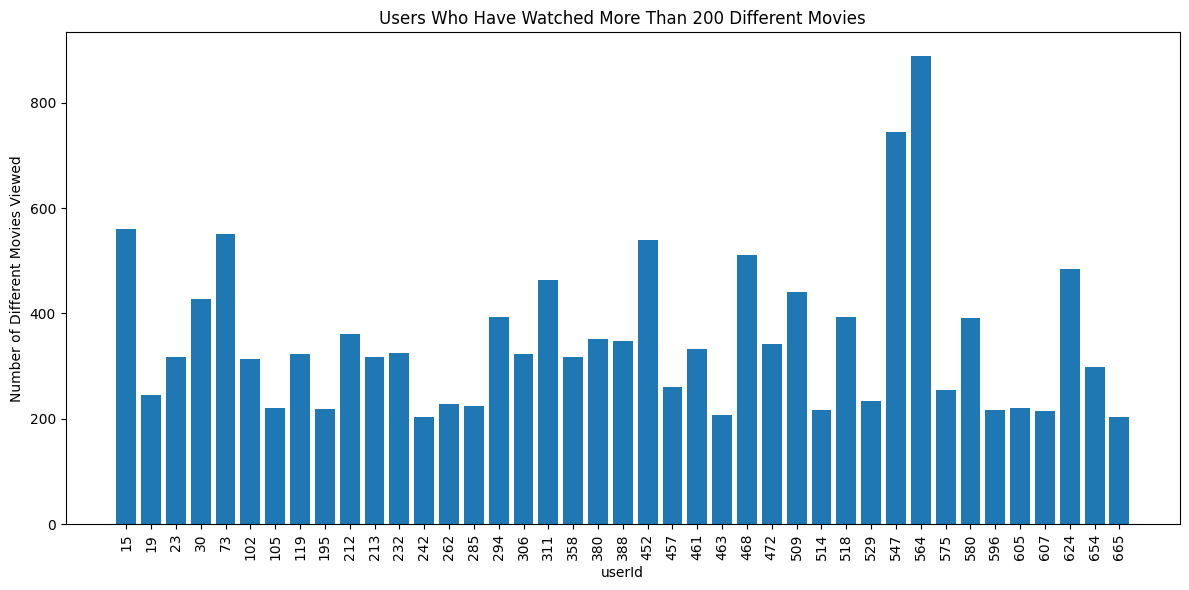

37254                  Ariel
37255    Shadows in Paradise
37256             Four Rooms
37257         Judgment Night
37258              Star Wars
                ...         
38145    Blondie on a Budget
38146    Blondie Plays Cupid
38147     Blondie Goes Latin
38148     Bis zum Ellenbogen
38149     Carry On Screaming
Name: title, Length: 896, dtype: object

In [645]:
# Merge the two dataframes on the movieId column
df_movies_with_ratings = pd.merge(ratings_df, movie_details_df, left_on="movieId", right_on="id", how="inner")
display(df_movies_with_ratings.describe()) # Get a High-level look at the datset

df_movie_filter = df_movies_with_ratings[['userId','movieId','rating','genres','overview','title']].fillna('')
display(df_movie_filter.head(100)) # Show a couple examples of the data

# Count the number of distinct users and movies
num_unique_titles = df_movie_filter['title'].nunique()
num_unique_users = df_movie_filter['userId'].nunique()
print(f"Number of distinct titles: {num_unique_titles}")
print(f"Number of distinct users: {num_unique_users}")

# Let's get a sense of volume for the most "active" users
user_title_counts = df_movie_filter.groupby('userId')['title'].nunique()
filtered_counts = user_title_counts[user_title_counts > 200] # Chose 200 because that looked to be where a manageable cutoff was for visualizing

# Plot the number of movies viewed for the most active users
plt.figure(figsize=(12, 6))
plt.bar(filtered_counts.index.astype(str), filtered_counts.values)
plt.xlabel('userId')
plt.ylabel('Number of Different Movies Viewed')
plt.title('Users Who Have Watched More Than 200 Different Movies')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

display(df_movie_filter[df_movie_filter['userId'] == 564]['title']) # Example

Given we are trying to use LDA as a form of "genre", we want to understand how many and what kind of genres are in the dataset.

In [646]:
# "Genres" are held in dictionaries within a column of the DataFrame, so we need to go one level further to work with those values
genre_ids = df_movies_with_ratings['genres'].dropna().apply(
    lambda x: [genre['id'] for genre in eval(x)] if isinstance(x, str) else []
) # Get Genre Id's

genre_names = df_movies_with_ratings['genres'].dropna().apply(
    lambda x: [genre['name'] for genre in eval(x)] if isinstance(x, str) else []
) # Get Genre names

# Convert into a single list of id's and names
all_genre_ids = [genre_id for sublist in genre_ids for genre_id in sublist]
all_genre_names = [genre_name for sublist in genre_names for genre_name in sublist]

# Count the number of unique id's
unique_genre_count = len(set(all_genre_ids))

print(f"Number of unique genre IDs: {unique_genre_count}")
print(f"Genre Names: {set(all_genre_names)}")

Number of unique genre IDs: 20
Genre Names: {'History', 'Action', 'Family', 'Adventure', 'Music', 'Mystery', 'Western', 'Comedy', 'Thriller', 'Documentary', 'Horror', 'TV Movie', 'Foreign', 'Science Fiction', 'Fantasy', 'Crime', 'Romance', 'War', 'Animation', 'Drama'}


Split Dataset into a Training set and Testing set

In [647]:
# Split the data into training and testing sets
train_df, test_df = train_test_split(df_movie_filter, test_size=0.2, random_state=42)

# Print the shapes of the resulting datasets
print(f"Training set shape: {train_df.shape}")
print(f"Testing set shape: {test_df.shape}")

Training set shape: (35995, 6)
Testing set shape: (8999, 6)


Select the User we want to Recommend Movies to

In [648]:
user_id = 508

Define a Function for the Pre-processing technique known as "Stemming"

In [649]:
def stem_text(text):
    stemmer = PorterStemmer()
    tokens = word_tokenize(text)
    stemmed = [stemmer.stem(token) for token in tokens]
    return ' '.join(stemmed)

1) Initialize Methods
2) Transform and Fit on Training Data
3) Transform and Predict on Testing Data

In [650]:
lda = LatentDirichletAllocation(n_components=unique_genre_count,n_jobs=-1, random_state=42) # set the Number of Topics to the Number of genres

# Define the 2 different Text Vectorization Techniques
## Remove English Stop Words & any words that show up too often or too few times
tfidf = TfidfVectorizer(norm='l2',stop_words='english', max_df=0.1, min_df =.001)
bow = CountVectorizer(stop_words='english', max_df=0.1, min_df=.001)

# Define Column Transformers
ct_tf = ColumnTransformer(
    transformers=[
        ('tfidf', tfidf, 'overview')  # Apply TF-IDF to the 'overview' column
    ]
)
ct_bow = ColumnTransformer(
    transformers=[
        ('bow', bow, 'overview')  # Apply BOW to the 'overview' column
    ]
)

# Create Pipelines to apply both Text Vectorization and LDA to the input data
pipe_tf = Pipeline(steps=[
    ('ct', ct_tf),
    ('lda', lda)
])

pipe_bow = Pipeline(steps=[
    ('ct', ct_bow),
    ('lda', lda)
])

# apply Stemming
train_df['overview_raw'] = train_df['overview'] # Create new column to apply stemming so we don't lose the input overviews


train_df['overview'] = train_df['overview'].apply(stem_text) # Apply stemming to each row of train_df['overview']

# Fit the model on the training data
pipe_tf.fit(train_df[['overview']].drop_duplicates())
pipe_bow.fit(train_df[['overview']].drop_duplicates())

# Transform the test data to get topic distributions
test_topic_distributions= pipe_tf.transform(test_df[['overview']])

# Extract the Transformers so we can see some of the outputs
tfidf_step = pipe_tf.named_steps['ct'].transformers_[0][1]
bow_step = pipe_bow.named_steps['ct'].transformers_[0][1]

# Get the feature names (words in the corpus)
feature_names_tf = tfidf_step.get_feature_names_out()
feature_names_bow = bow_step.get_feature_names_out()

# Show the Number of Dimensions for our word corpus
print(len(feature_names_tf))
print(len(feature_names_bow))

4212
4212


We want to learn a little more about how TF-IDF and BOW affect the same corpus.

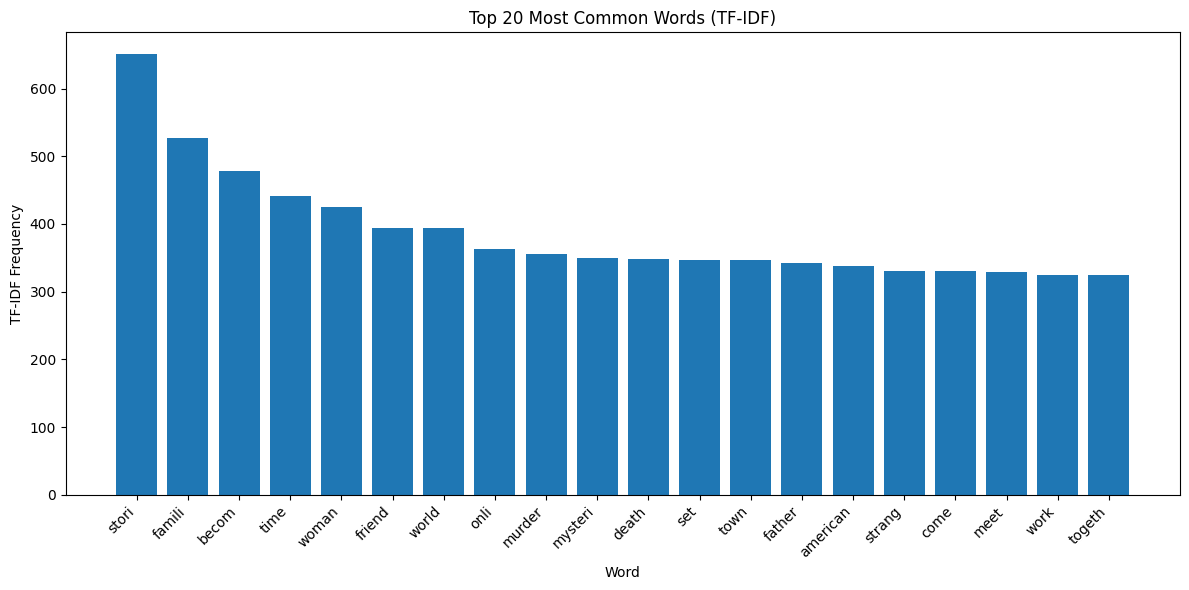

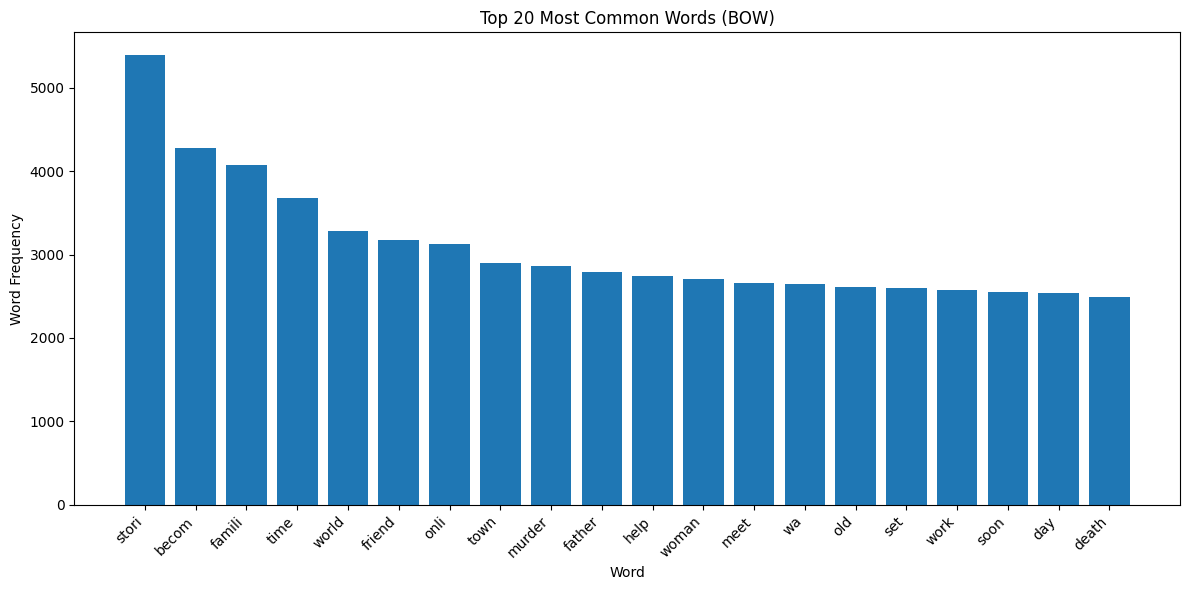

'woman tf-idf score': 425.1146481041111
IDF score for 'woman': 3.637536416774552
'woman BOW score': 2706


In [651]:
# Get summary tf-idf scores for every word in the corpus
tfidf_matrix = tfidf_step.transform(train_df['overview'])
tfidf_frequencies = tfidf_matrix.sum(axis=0).A1  # Convert to 1D array
tfidf_word_freq = dict(zip(feature_names_tf, tfidf_frequencies))


# Get the 20 most common words
top_words = sorted(tfidf_word_freq.items(), key=lambda x: x[1], reverse=True)[:20] # Order words by their tfidf scores
words, freqs = zip(*top_words)

plt.figure(figsize=(12, 6))
plt.bar(words, freqs)
plt.xticks(rotation=45, ha='right')
plt.title('Top 20 Most Common Words (TF-IDF)')
plt.xlabel('Word')
plt.ylabel('TF-IDF Frequency')
plt.tight_layout()
plt.show()

# Similarly, for Bag-of-Words
bow_matrix = bow_step.transform(train_df['overview'])
bow_frequencies = bow_matrix.sum(axis=0).A1
bow_word_freq = dict(zip(feature_names_bow, bow_frequencies))
# Get the 20 most common words
top_words = sorted(bow_word_freq.items(), key=lambda x: x[1], reverse=True)[:20]
words, freqs = zip(*top_words)

plt.figure(figsize=(12, 6))
plt.bar(words, freqs)
plt.xticks(rotation=45, ha='right')
plt.title('Top 20 Most Common Words (BOW)')
plt.xlabel('Word')
plt.ylabel('Word Frequency')
plt.tight_layout()
plt.show()

# Example
print(f"'woman tf-idf score': {tfidf_word_freq['woman']}")

idx = tfidf_step.vocabulary_['woman'] # Get index of "woman" in the vocabulary of the corpus
idf_score = tfidf_step.idf_[idx] # Get Inverse Document Frequency
print(f"IDF score for 'woman': {idf_score}")

print(f"'woman BOW score': {bow_word_freq['woman']}")


Define Function for Weighting the Distributions

In [652]:
def weighting(row):
    return [x * row['rating'] for x in row['topic_distribution']]

1) Extract topic Distributions from Nested List
2) Apply weighting
3) Get mean distribution for each user

In [653]:
# Assign Topic Distributions into the dataset, then weight each distribution by the rating the user gave the movie
test_df['topic_distribution'] = test_topic_distributions.tolist()
display(test_df.loc[test_df['userId'] == user_id,['userId','title','topic_distribution']])

test_df['dominant_topic'] = test_df['topic_distribution'].apply(lambda x: np.argmax(x)) # Just for my knowledge, create column of the "Most Likely" Topic
test_df['weighted_topic_distribution'] = test_df.apply(weighting, axis=1) # Apply Weighting

# Assigning each Topic its own column to make data manipulations easier
topic_dist_cols = pd.DataFrame(test_df['weighted_topic_distribution'].tolist(),
                                index=test_df.index).add_prefix('weighted_topic_') # Create weighted distribution columns

test_df = pd.concat([test_df, topic_dist_cols], axis=1) # add columns to the test DataFrame


# Group by userId, calculate the mean for each weighted_topic column, create new columns in DataFrame
user_topic_means = test_df.groupby('userId')[topic_dist_cols].mean().add_prefix('average_')

# Merge the averages back into test_df
test_df = test_df.merge(user_topic_means, left_on='userId', right_index=True, how='left')

# Get all the average weighted columns
avg_topic_cols = [col for col in test_df.columns if col.startswith('average_weighted_topic_')]

user_distribution_df = test_df[['userId'] + avg_topic_cols].drop_duplicates() # Only keep one row for each User
user_distribution_df[avg_topic_cols] = normalize(user_distribution_df[avg_topic_cols],norm='l1') # Need the User's Likelihood Distributions to sum to 1
print(user_distribution_df[avg_topic_cols].sum(axis=1)) # Check Normalization works as expected

# Transform weighted columns back into a single column
user_distribution_df['average_weighted_topic_list'] = user_distribution_df[avg_topic_cols].values.tolist()


# Display the first few rows of the test DataFrame with topic distributions
display(test_df[['userId','movieId','title', 'overview','genres', 'topic_distribution', 'dominant_topic']].head(100))

,userId,title,topic_distribution
32469,508,Titanic,"[0.008912042134965539, 0.008912042123191483, 0..."
32446,508,Grill Point,"[0.010640618777150262, 0.010640618856876944, 0..."
32444,508,Terminator 3: Rise of the Machines,"[0.010868708681493134, 0.010868708706053156, 0..."
32458,508,Reservoir Dogs,"[0.014171295258103015, 0.01417129530230982, 0...."
32435,508,Star Wars,"[0.7811320663325353, 0.011519364924941138, 0.0..."
32445,508,The Science of Sleep,"[0.018414223397465755, 0.01841422354695275, 0...."
32465,508,The Conversation,"[0.00941377976638351, 0.009413779986794678, 0...."
32440,508,A Clockwork Orange,"[0.0855926515400558, 0.010724073946072749, 0.7..."
32454,508,Bend It Like Beckham,"[0.011424494967963926, 0.011424495057364438, 0..."
32468,508,To Kill a Mockingbird,"[0.008641176518742858, 0.00864117655983233, 0...."


TypeError: unhashable type: 'DataFrame'

Let's examine User 508's topic distributions for each movie seen

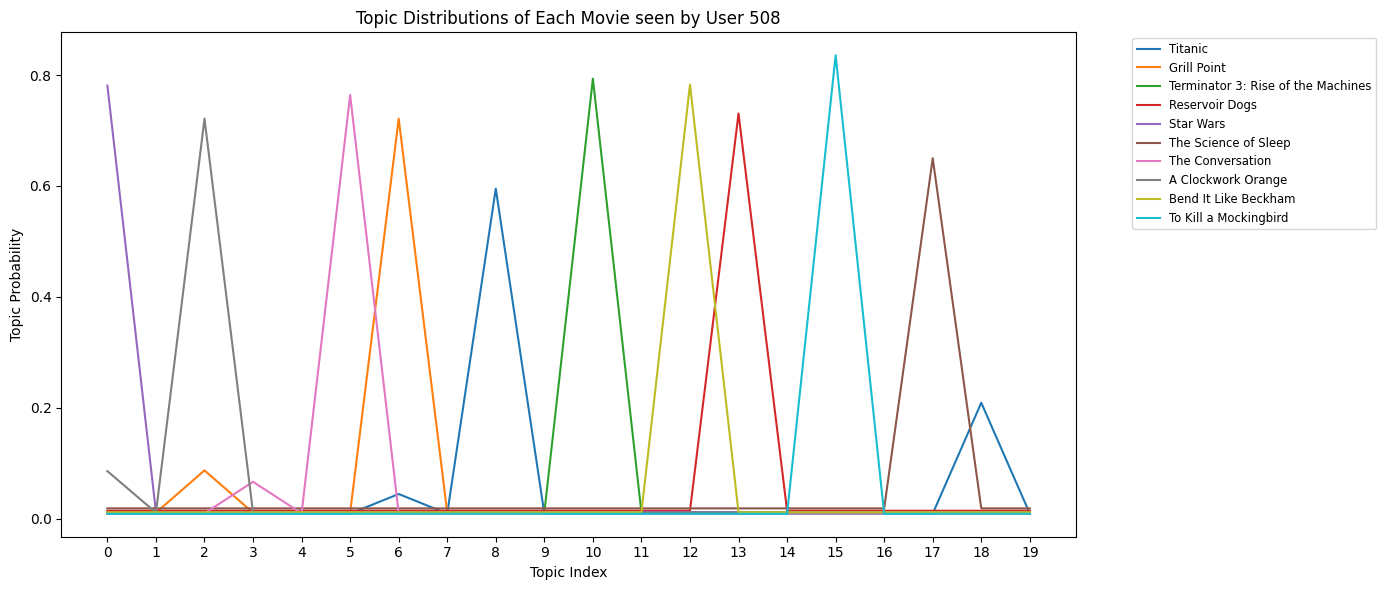

In [ ]:
# Plot the topic distributions for each title for userId = 508

user_topic_df = test_df.loc[test_df['userId'] == user_id, ['title', 'topic_distribution']].copy()

plt.figure(figsize=(14, 6))

for idx, row in user_topic_df.iterrows():
    plt.plot(row['topic_distribution'], label=row['title'])
    
plt.xticks(range(0,20))
plt.xlabel('Topic Index')
plt.ylabel('Topic Probability')
plt.title(f'Topic Distributions of Each Movie seen by User {user_id}')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=1)
plt.tight_layout()
plt.show()

Now, let's look at the weighted distribution (before normalization)

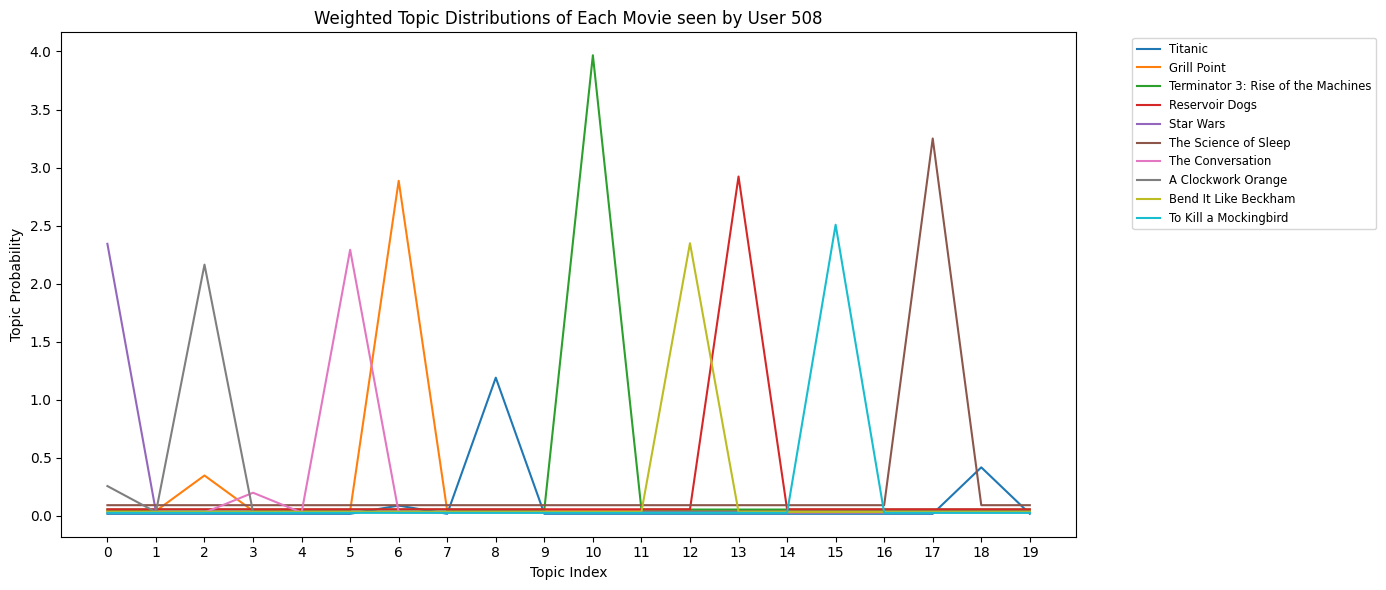

In [ ]:


user_topic_df = test_df.loc[test_df['userId'] == user_id, ['title', 'weighted_topic_distribution']].copy()

plt.figure(figsize=(14, 6))
for idx, row in user_topic_df.iterrows():
    plt.plot(row['weighted_topic_distribution'], label=row['title'])
    
plt.xticks(range(0,20))
plt.xlabel('Topic Index')
plt.ylabel('Topic Probability')
plt.title(f'Weighted Topic Distributions of Each Movie seen by User {user_id}')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=1)
plt.tight_layout()
plt.show()

Now, the normalized mean distribution for User 508

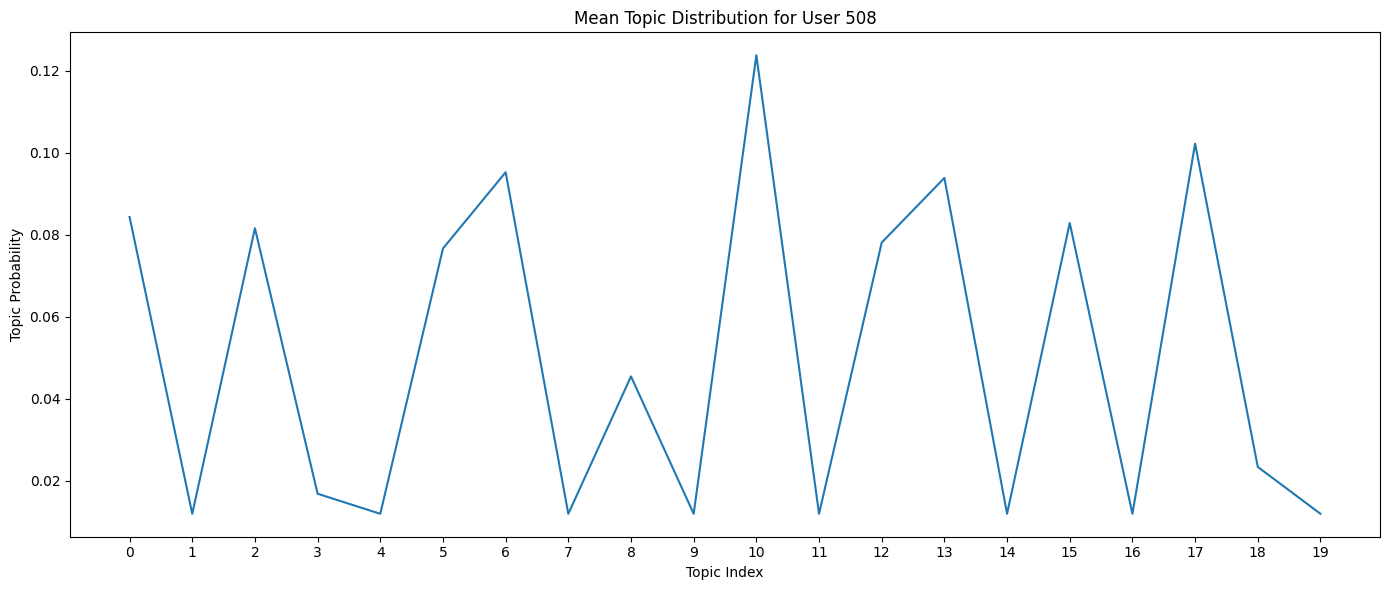

In [ ]:

user_topic_df = user_distribution_df.loc[user_distribution_df['userId'] == user_id, ['userId','average_weighted_topic_list']].copy()

plt.figure(figsize=(14, 6))
plt.plot(user_topic_df['average_weighted_topic_list'].iloc[0], label='508')
plt.xticks(range(0,20))
plt.xlabel('Topic Index')
plt.ylabel('Topic Probability')
plt.title(f'Mean Topic Distribution for User {user_id}')
plt.tight_layout()
plt.show()

Before finding a similar user, let me get a sense for the movies and ratings for User 508 so I can validate any recommendations we make

In [ ]:
# Show the counts for the values within genres in test_df for userId = 508 and show the average rating for each genre

user_rows = test_df.loc[test_df['userId'] == user_id, ['genres', 'rating']] # Get the rows in the dataFrame for User 508

# Initialize variables to hold our genre counts and ratings
genre_counts = Counter()
genre_ratings = defaultdict(list)


for idx, row in user_rows.iterrows():
    genres = row['genres']
    rating = row['rating']
    if genres:
            genres_list = ast.literal_eval(genres) # Ensure the data in the row['genres'] is a list
            for genre in genres_list:
                genre_name = genre['name'] # get Genre in list
                genre_counts[genre_name] += 1 # add 1 to the count
                genre_ratings[genre_name].append(rating) # add rating
    else:
         continue

# Calculate average rating for each genre
genre_avg_rating = {genre: (sum(ratings) / len(ratings)) for genre, ratings in genre_ratings.items()}

print("Genre counts for userId 508 in test_df:")
print(dict(genre_counts))

sorted_genre_avg_rating = dict(sorted(genre_avg_rating.items(), key=lambda x: x[1], reverse=True)) # Sort by the highest rated genres

print("Average rating for each genre for userId 508 in test_df (descending order):")
print(sorted_genre_avg_rating)

Genre counts for userId 508 in test_df:
{'Drama': 7, 'Romance': 2, 'Thriller': 3, 'Comedy': 3, 'Action': 2, 'Science Fiction': 3, 'Crime': 3, 'Adventure': 1, 'Fantasy': 1, 'Mystery': 1}
Average rating for each genre for userId 508 in test_df (descending order):
{'Fantasy': 5.0, 'Comedy': 4.0, 'Action': 4.0, 'Thriller': 3.6666666666666665, 'Science Fiction': 3.6666666666666665, 'Crime': 3.3333333333333335, 'Drama': 3.2857142857142856, 'Adventure': 3.0, 'Mystery': 3.0, 'Romance': 2.5}


Define Function for Sum Squared Error (used to evaluate user distribution similarity)

In [ ]:
def sum_squared_error(row):
    return np.sum((np.array(row['average_weighted_topic_list']) - np.array(user_508_vector)) ** 2)

Recommend 3 movies from the "Most Similar" Users:
1) Use Nearest Neighbors to find similar users (varying on distance metric)
2) Find 3 movies that User 508 has not seen from the "most similar" user

32469    [0.08434568309093664, 0.011961573530662156, 0....
Name: average_weighted_topic_list, dtype: object
Nearest neighbors for user 508: [508  32 619]


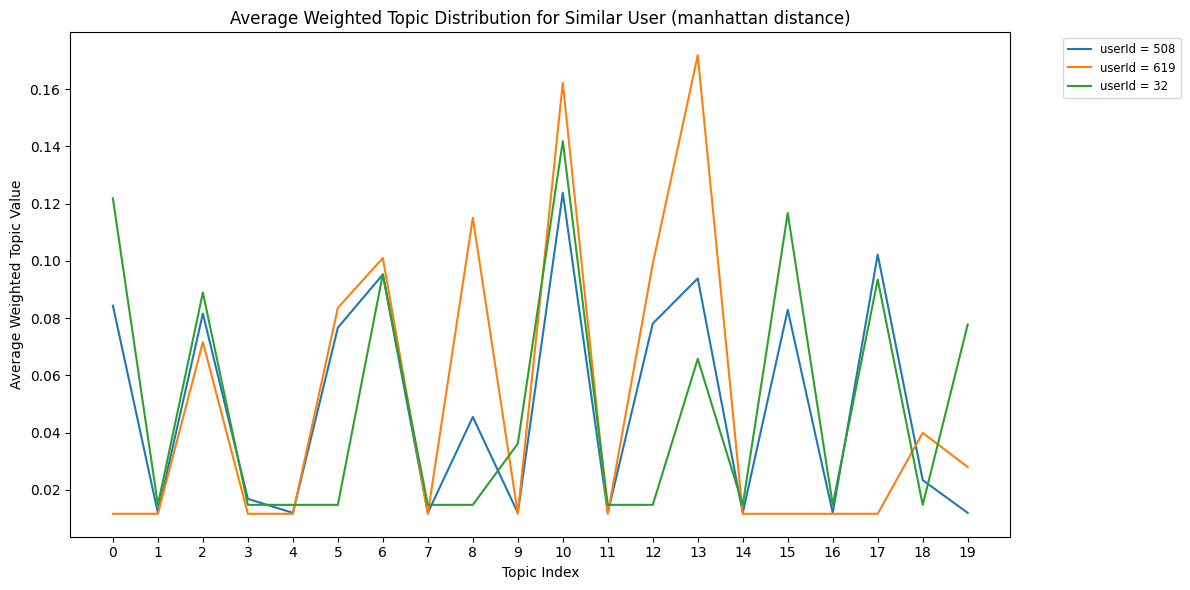

       userId  sse_vs_508
42018     619    0.032125
2672       32    0.017616
Recommended title for user 508: ['Three Colors: Red', 'Aliens vs Predator: Requiem', 'Popular Music'], Rated [5.0, 4.0, 4.0] by User 32


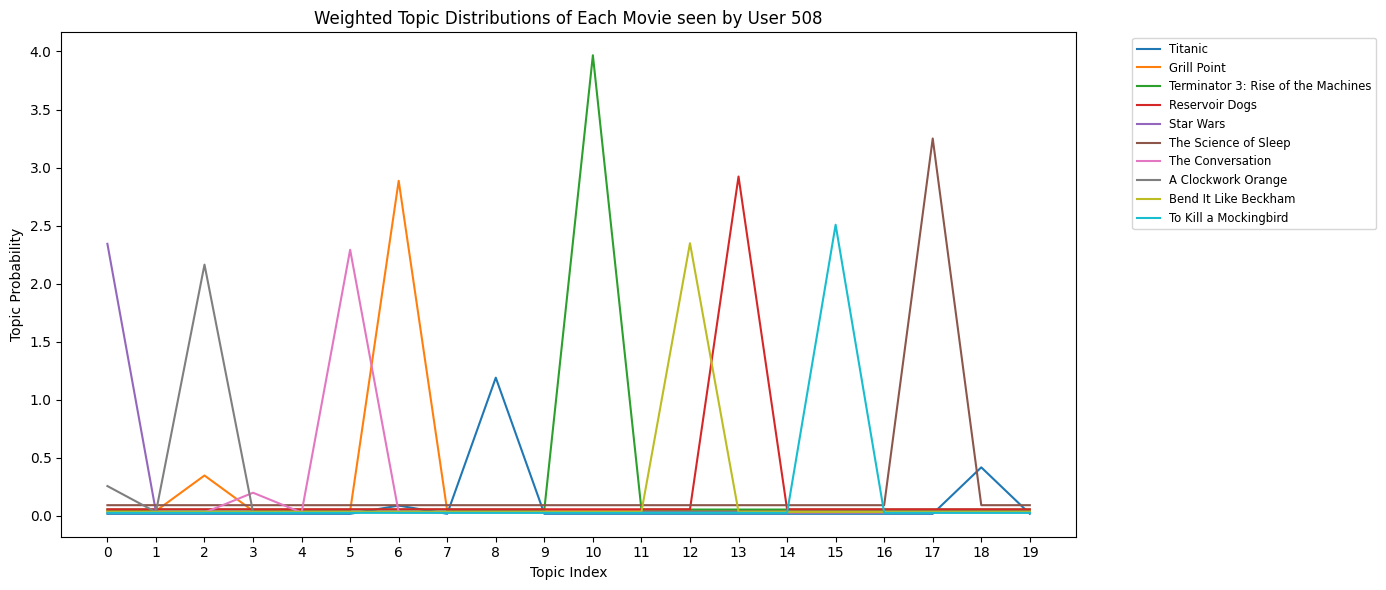

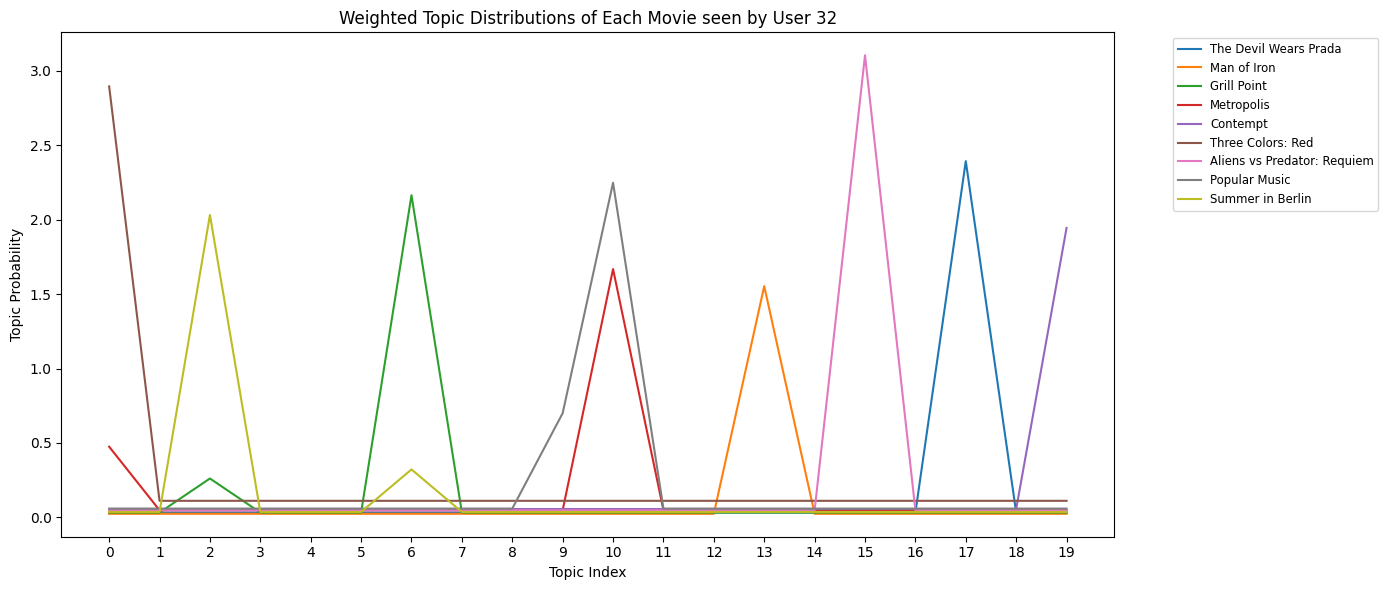

Nearest neighbors for user 508: [508  32 463]


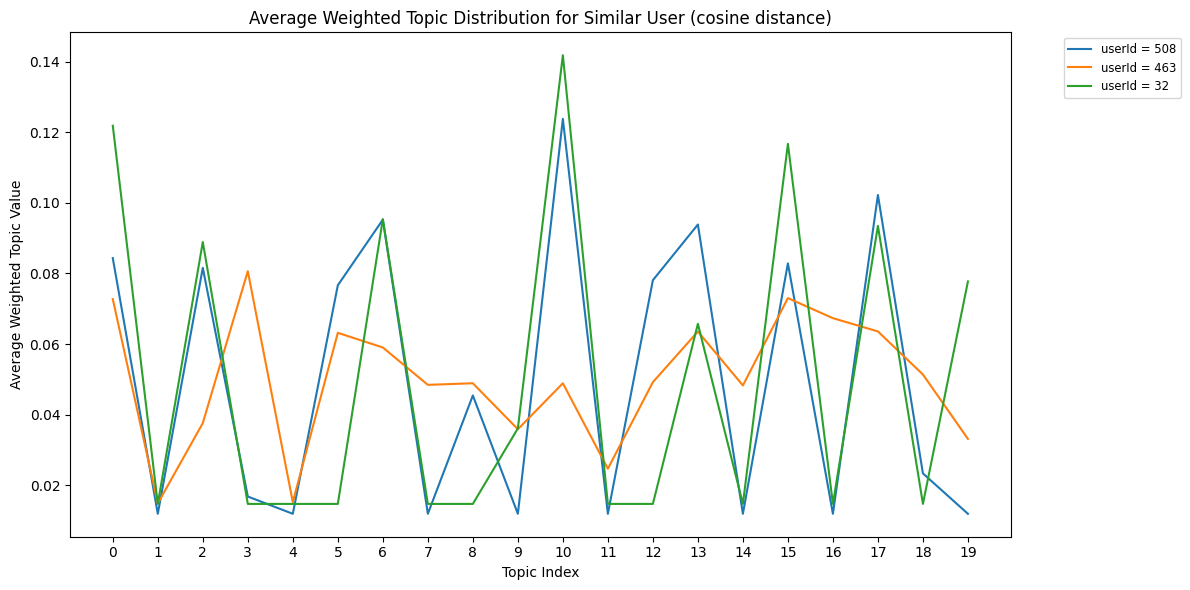

       userId  sse_vs_508
29498     463    0.024289
2672       32    0.017616
Recommended title for user 508: ['Three Colors: Red', 'Aliens vs Predator: Requiem', 'Popular Music'], Rated [5.0, 4.0, 4.0] by User 32


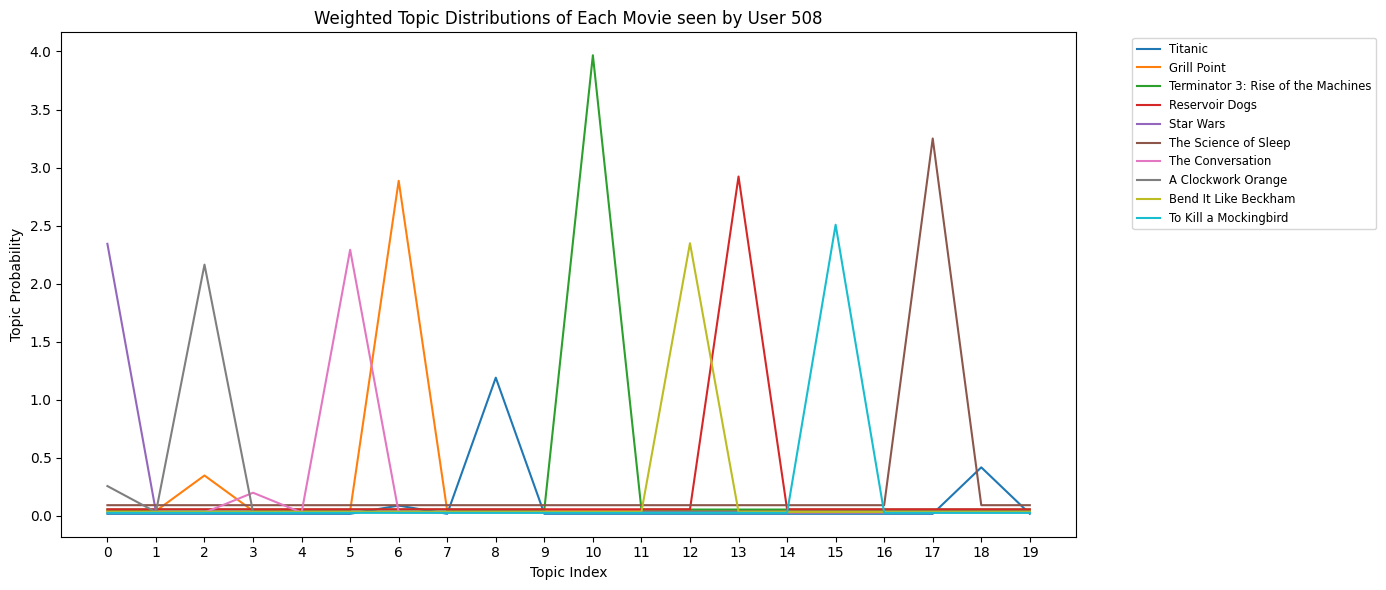

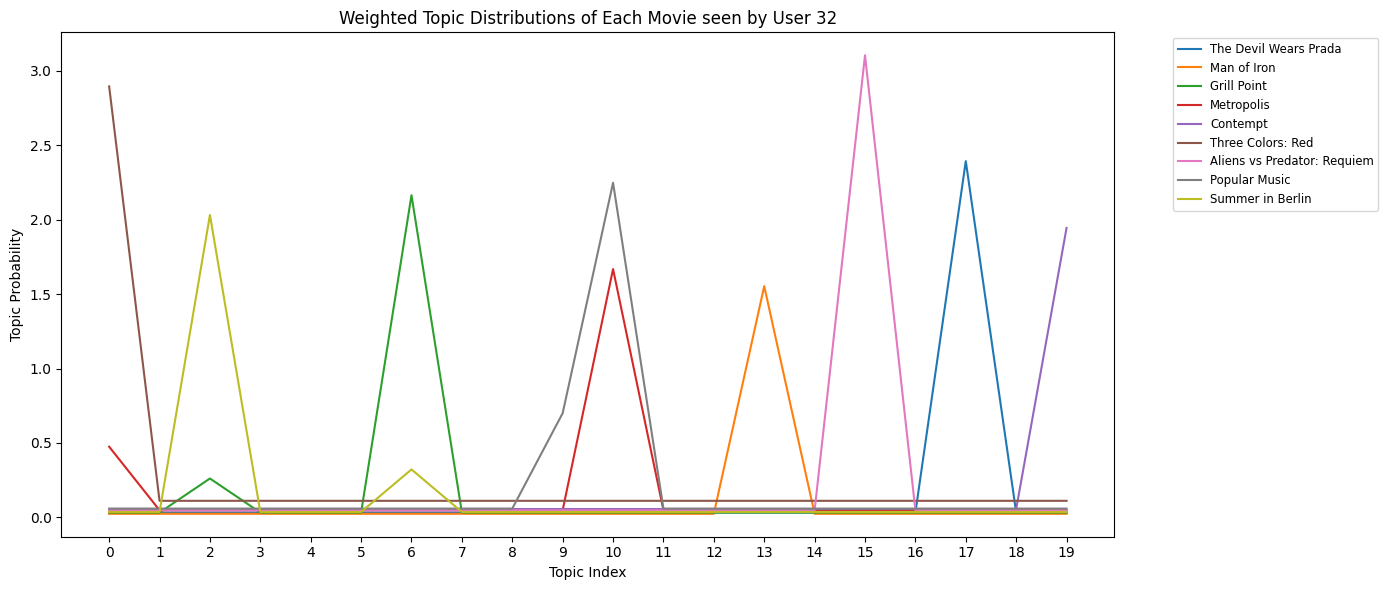

Nearest neighbors for user 508: [508  32 463]


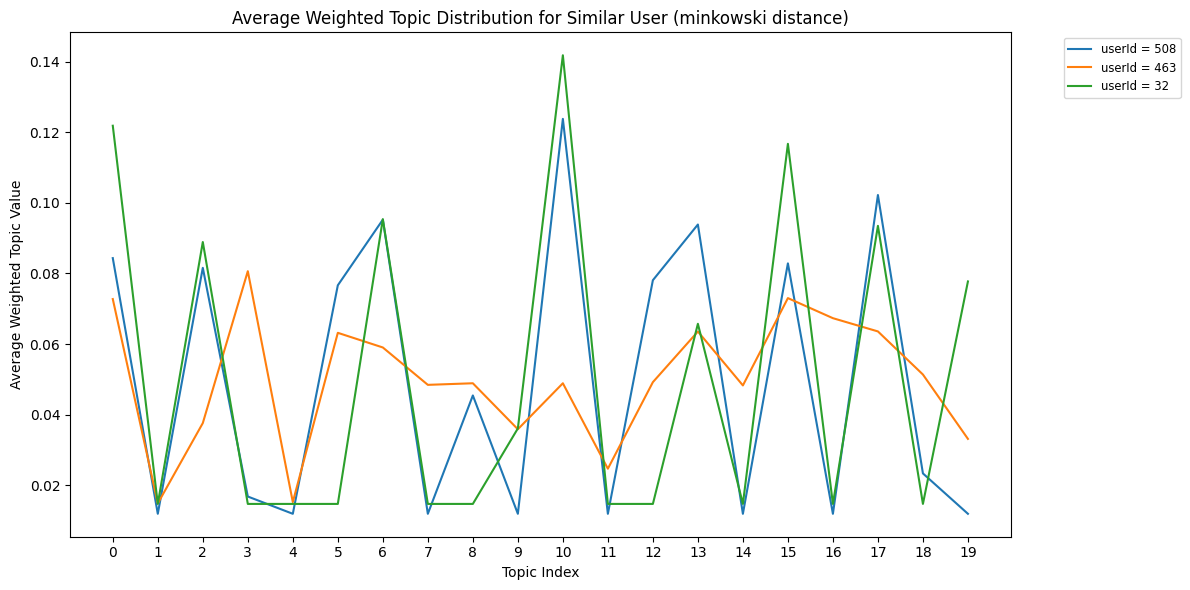

       userId  sse_vs_508
29498     463    0.024289
2672       32    0.017616
Recommended title for user 508: ['Three Colors: Red', 'Aliens vs Predator: Requiem', 'Popular Music'], Rated [5.0, 4.0, 4.0] by User 32


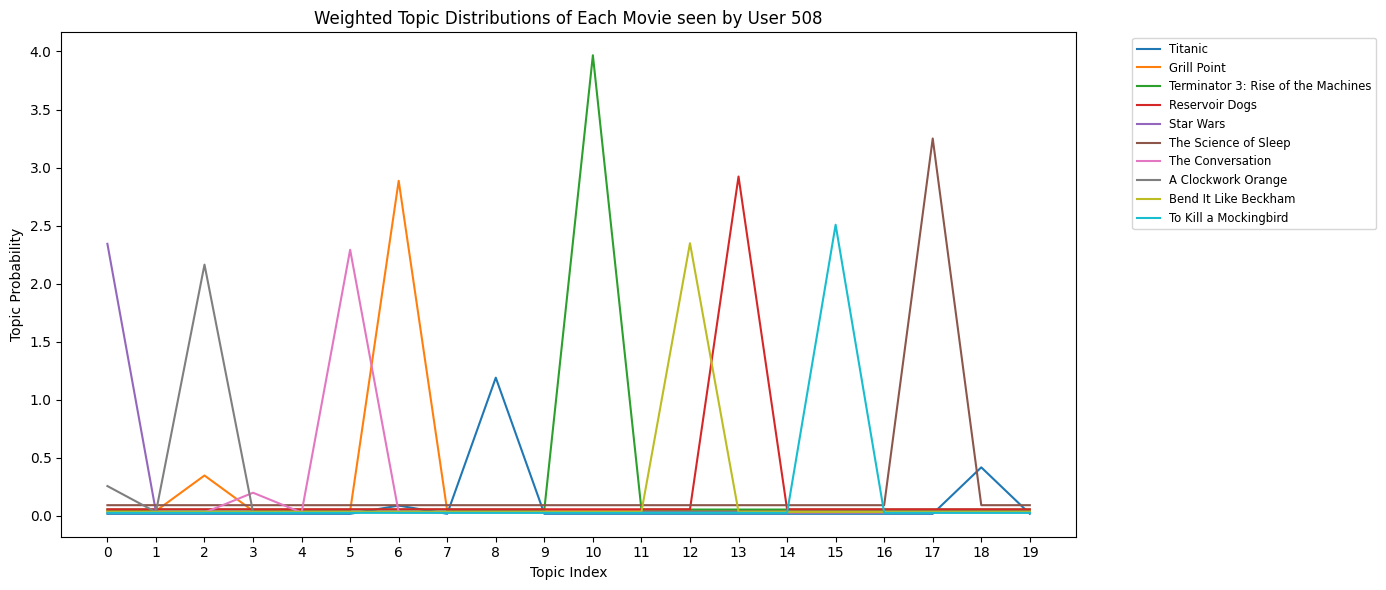

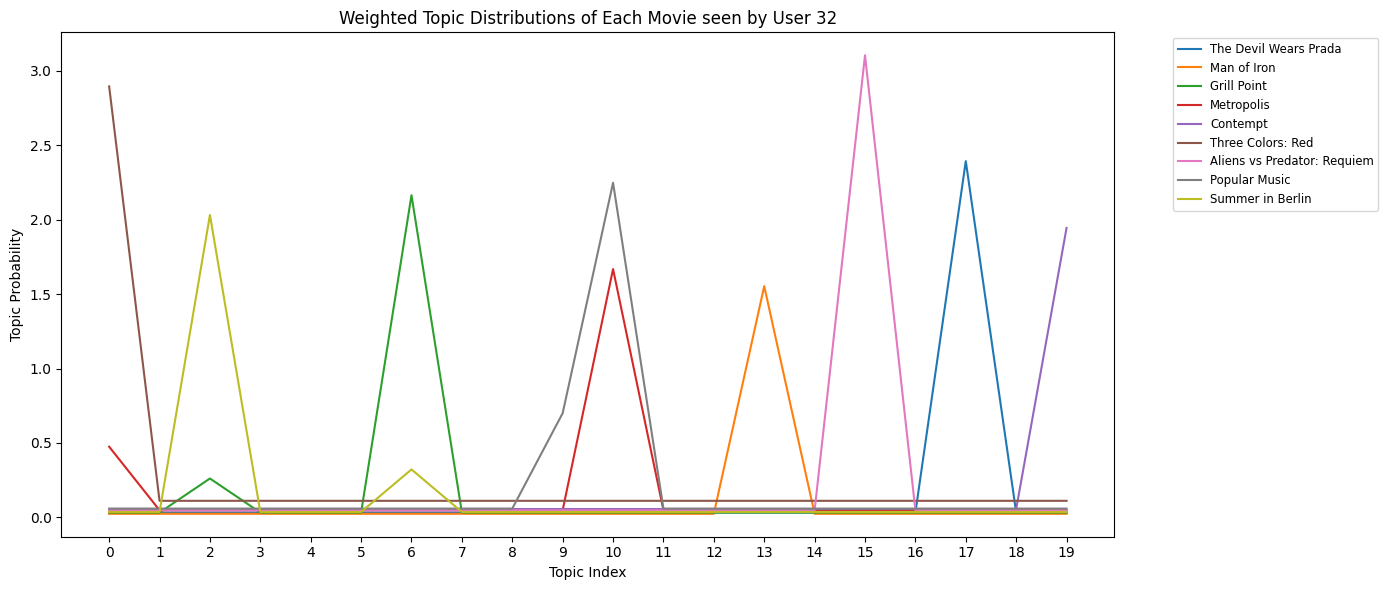

,userId,average_weighted_topic_list,sse_vs_508
32469,508,"[0.08434568309093664, 0.011961573530662156, 0....",NaN
29498,463,"[0.07275620563323724, 0.014895119072402051, 0....",0.024289
2672,32,"[0.12182660317106832, 0.014756690741307508, 0....",0.017616


In [ ]:

user_df = user_distribution_df[['userId', 'average_weighted_topic_list']].drop_duplicates(subset=['userId']) # Double Check for no duplicate users
user508_topic_df = test_df.loc[test_df['userId'] == user_id, ['title', 'weighted_topic_distribution']].copy() # Get the row for User 508

metrics = ['manhattan','cosine','minkowski'] # distance metrics

# Find the "Most Similar" user mean topic distrbutions for each distance metric
for met in metrics:

    nearest_user = NearestNeighbors(n_neighbors=5, metric=met, n_jobs=-1) # Initialize the NearestNeighbors model

    nearest_user.fit(user_df['average_weighted_topic_list'].tolist(), user_df['userId'].tolist()) # Fit the model with all users and their topic distributions
    
    distances, indices = nearest_user.kneighbors([user_df.loc[user_df['userId'] == user_id, 'average_weighted_topic_list'].values[0]]) # Find the nearest neighbors for the specified user

    nearest_user_ids = user_df.iloc[indices[0]]['userId'].values[0:3] # Get the user IDs of the nearest neighbors
    print(f"Nearest neighbors for user {user_id}: {nearest_user_ids}")

    subset = user_df[user_df['userId'].isin(nearest_user_ids)] # Get the DataFrame values for each of the 3 users

    # Plot the user distributions with our user of interest
    plt.figure(figsize=(12, 6))

    for idx, row in subset.iterrows():
        plt.plot(row['average_weighted_topic_list'], label=f"userId = {row['userId']}")

    plt.xticks(range(0,20))
    plt.xlabel('Topic Index')
    plt.ylabel('Average Weighted Topic Value')
    plt.title(f'Average Weighted Topic Distribution for Similar User ({met} distance)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=1)
    plt.tight_layout()
    plt.show()

    # Get the SSE between our user of interest and the similar users
    user_508_vector = user_df[user_df['userId'] == user_id]['average_weighted_topic_list'].values[0]

    user_df['sse_vs_508'] = user_df.apply(
        lambda row: sum_squared_error(row) if row['userId'] != user_id and row['userId'] in nearest_user_ids else np.nan, axis=1
    )
    print(user_df[['userId', 'sse_vs_508']].dropna())

    min_sse_user = user_df[user_df['userId'] != user_id].loc[user_df['sse_vs_508'].idxmin(), 'userId'] # What user has the smallest SSE?

    # Recommend Movies
    titles_508 = set(test_df[test_df['userId'] == user_id]['title']) # Get titles already seen by user 508

    user_min_sse_df = test_df[test_df['userId'] == min_sse_user] # Get the min SSE user's seen movies
    user_min_sse_df = user_min_sse_df[~user_min_sse_df['title'].isin(titles_508)] # Get the highest rated title for the minimal SSE user that user 508 hasn't seen

    # Return the 3 Highest Rated movies for User 508
    if not user_min_sse_df.empty:
        top_titles = user_min_sse_df.sort_values('rating', ascending=False).head(3)['title'].tolist()
        top_ratings = user_min_sse_df.sort_values('rating', ascending=False).head(3)['rating'].tolist()
        print(f"Recommended title for user 508: {top_titles}, Rated {top_ratings} by User {min_sse_user}")
    else:
        print("No unseen titles to recommend from the minimal SSE user.")

    # Plot the movie dsitributions for the user of interest and the "Most Similar" user
    user_topic_df = test_df.loc[test_df['userId'] == min_sse_user, ['title', 'weighted_topic_distribution']].copy()
    
    plt.figure(figsize=(14, 6))

    for idx, row in user508_topic_df.iterrows():
        plt.plot(row['weighted_topic_distribution'], label=row['title'])

    plt.xticks(range(0,20))
    plt.xlabel('Topic Index')
    plt.ylabel('Topic Probability')
    plt.title(f'Weighted Topic Distributions of Each Movie seen by User {user_id}')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=1)
    plt.tight_layout()
    plt.show()


    plt.figure(figsize=(14, 6))

    for idx, row in user_topic_df.iterrows():
        plt.plot(row['weighted_topic_distribution'], label=row['title'])
        
    plt.xticks(range(0,20))
    plt.xlabel('Topic Index')
    plt.ylabel('Topic Probability')
    plt.title(f'Weighted Topic Distributions of Each Movie seen by User {min_sse_user}')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=1)
    plt.tight_layout()
    plt.show()


display(user_df[user_df['userId'].isin(nearest_user_ids)])


Let's scope the topic distributions to just User 508 and its most similar User

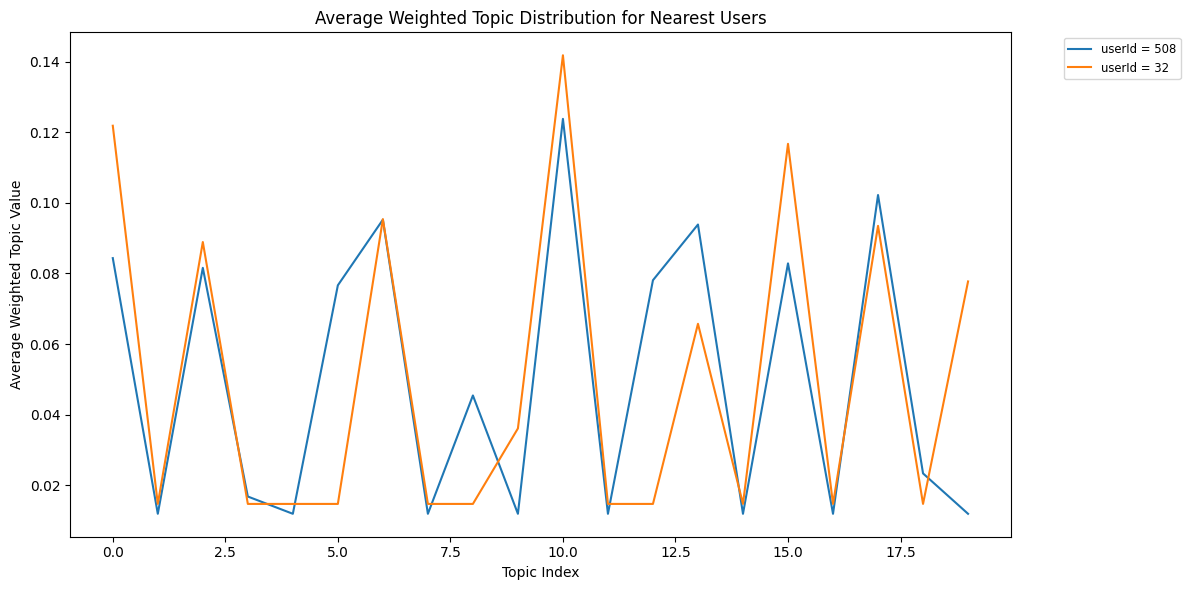

In [ ]:
# Plot the average_weighted_topic_list values for each userId in user_df[user_df['userId'].isin(nearest_user_ids)]

subset = user_df[user_df['userId'].isin(nearest_user_ids)]

plt.figure(figsize=(12, 6))
for idx, row in subset.iterrows():
    plt.plot(row['average_weighted_topic_list'], label=f"userId = {row['userId']}")

plt.xlabel('Topic Index')
plt.ylabel('Average Weighted Topic Value')
plt.title('Average Weighted Topic Distribution for Nearest Users')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=1)
plt.tight_layout()
plt.show()